# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import division
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train)
        train_acc = (svm.predict(X_train_feats) == y_train).mean()
        val_acc = (svm.predict(X_val_feats) == y_val).mean()
        
        results[(lr, reg)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-09 reg 1.000000e+05 train accuracy: 0.439714 val accuracy: 0.435000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.441939 val accuracy: 0.431000
lr 1.000000e-09 reg 1.000000e+07 train accuracy: 0.438041 val accuracy: 0.435000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.436224 val accuracy: 0.429000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.434694 val accuracy: 0.430000
lr 1.000000e-08 reg 1.000000e+07 train accuracy: 0.438163 val accuracy: 0.436000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.437878 val accuracy: 0.439000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.436327 val accuracy: 0.431000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.439510 val accuracy: 0.436000
best validation accuracy achieved during cross-validation: 0.439000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.439


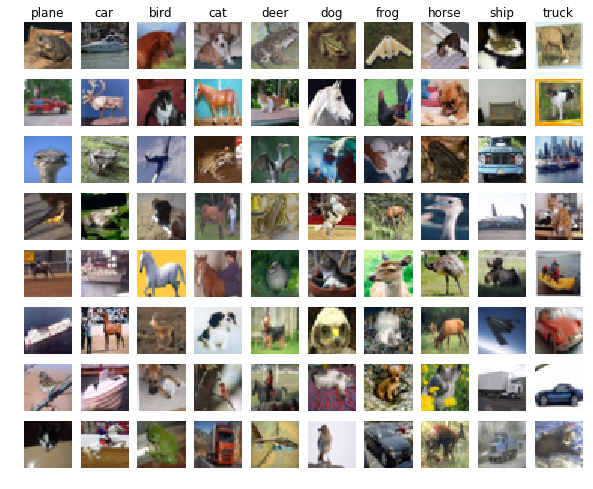

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = dict()
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)

        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros((1, output_size))

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        loss = None

        # Compute the forward pass
        hidden_layer = np.dot(X, W1)

        # ReLu activation
        hidden_layer = np.maximum(0, hidden_layer + b1)

        scores = np.dot(hidden_layer, W2) + b2
        scores += -np.max(scores)

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        #############################################################################
        # Finish the forward pass, and compute the loss. This should include        #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss. So that your results match ours, multiply the            #
        # regularization loss by 0.5                                                #
        #############################################################################
        
        exp_scores = np.exp(scores)
        probs = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
        log_probs = -np.log(probs[range(N), y])
        
        data_loss = np.sum(log_probs/N)
        reg_loss = 0.5 * reg * np.sum(W1 * W1) + 0.5 * reg * np.sum(W2 * W2)
        loss = data_loss + reg_loss
         
        grads = {}
        
        #############################################################################
        #       Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        dscores = probs
        dscores[range(N), y] -= 1
        dscores /= N

        grads['W2'] = np.dot(hidden_layer.T, dscores)
        grads['b2'] = np.sum(dscores, axis=0, keepdims=True)

        dhidden = np.dot(dscores, W2.T)
        dhidden[hidden_layer <= 0] = 0

        grads['W1'] = np.dot(X.T, dhidden)
        grads['b1'] = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        grads['W2'] += reg * W2
        grads['W1'] += reg * W1

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3,
              learning_rate_decay=0.95,
              reg=1e-5,
              num_iters=100,
              batch_size=200,
              verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train, dim = X.shape
        indices = np.arange(num_train)
        iterations_per_epoch = max(num_train / batch_size, 1)

        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.params['W1'] is None:
            self.params['W1'] = 0.001 * np.random.randn(dim, num_classes)

        if self.params['W2'] is None:
            self.params['W2'] = 0.001 * np.random.randn(dim, num_classes)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in xrange(num_iters):
            X_batch = None
            y_batch = None

            # Create a random minibatch of training data and labels, storing
            # them in X_batch and y_batch respectively.                     
 
            sample = np.random.choice(indices, batch_size, replace=True)
            X_batch = X[sample, :]
            y_batch = y[sample]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Use the gradients in the grads dictionary to update the
            # parameters of the network (stored in the dictionary self.params)
            # using stochastic gradient descent. 
            
            self.params['W2'] += -learning_rate * grads['W2']
            self.params['b2'] += -learning_rate * grads['b2']
            self.params['W1'] += -learning_rate * grads['W1']
            self.params['b1'] += -learning_rate * grads['b1'][0]
            
            
            if verbose and it % 100 == 0:
                print 'iteration %d / %d: loss %f' % (it, num_iters, loss)

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        hidden_layer = np.maximum(np.dot(X, W1) + b1, 0)
        scores = np.dot(hidden_layer, W2) + b2
        y_pred = np.argmax(scores, axis=1)
 
        return y_pred

In [8]:
n = 50
X_train_sample = X_train_feats[:n]
y_train_sample = y_train[:n]
X_val_sample = X_val_feats[:n]
y_val_sample = y_val[:n]

input_dim = X_train_sample.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = 10**np.random.uniform(1e-3, 1e-5, 10)
regs = 10**np.random.uniform(-5, 5, 10)

best_net = None
results = {}
best_val = -1

results = {}

# Train the network
for lr in learning_rates:
    for reg in regs:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_sample,
                          y_train_sample,
                          X_val_sample,
                          y_val_sample,
                          num_iters=200,
                          batch_size=200,
                          learning_rate=lr,
                          learning_rate_decay=.95,
                          reg=reg,
                          verbose=False)
        
        train_acc = (net.predict(X_train_feats) == y_train).mean()
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_net = net
            best_val = val_acc

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000364e+00 reg 3.299131e-05 train accuracy: 0.224959 val accuracy: 0.233000
lr 1.000364e+00 reg 1.825306e-03 train accuracy: 0.223653 val accuracy: 0.220000
lr 1.000364e+00 reg 4.789123e-03 train accuracy: 0.224102 val accuracy: 0.223000
lr 1.000364e+00 reg 4.990373e-03 train accuracy: 0.223327 val accuracy: 0.228000
lr 1.000364e+00 reg 6.271673e-03 train accuracy: 0.222714 val accuracy: 0.223000
lr 1.000364e+00 reg 5.725057e-02 train accuracy: 0.219612 val accuracy: 0.220000
lr 1.000364e+00 reg 2.969321e-01 train accuracy: 0.184286 val accuracy: 0.194000
lr 1.000364e+00 reg 5.475988e+00 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000364e+00 reg 3.421062e+02 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000364e+00 reg 5.848577e+02 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000534e+00 reg 3.299131e-05 train accuracy: 0.223449 val accuracy: 0.218000
lr 1.000534e+00 reg 1.825306e-03 train accuracy: 0.224429 val accuracy: 0.226000
lr 1.000534e+00 reg 4.789123

/Users/kevin/Desktop/Stanford/CS231/assignment1/.env/lib/python2.7/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in true_divide
/Users/kevin/Desktop/Stanford/CS231/assignment1/.env/lib/python2.7/site-packages/ipykernel/__main__.py:91: RuntimeWarning: divide by zero encountered in log
/Users/kevin/Desktop/Stanford/CS231/assignment1/.env/lib/python2.7/site-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in less_equal


In [9]:
sorted(results)[0][0]

1.0003636139549841

In [10]:
input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = [sorted(results)[0][0]] #[1.000140e+00] # 10**np.random.uniform(1e-3, 1e-5, 10)
regs = [sorted(results)[0][1]] #[3.304221e-05] # 10**np.random.uniform(-5, 5, 10)

best_net = None
results = {}
best_val = -1

results = {}

################################################################################
# Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

# Train the network
for lr in learning_rates:
    for reg in regs:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats,
                          y_train,
                          X_val_feats,
                          y_val,
                          num_iters=2000,
                          batch_size=200,
                          learning_rate=lr,
                          learning_rate_decay=.95,
                          reg=reg,
                          verbose=False)
        
        train_acc = (net.predict(X_train_feats) == y_train).mean()
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_net = net
            best_val = val_acc

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000364e+00 reg 3.299131e-05 train accuracy: 0.788980 val accuracy: 0.572000
best validation accuracy achieved during cross-validation: 0.572000


In [11]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.561


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!